<a href="https://colab.research.google.com/github/tsakailab/iip/blob/main/sandbox/visualizing_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://discuss.pytorch.org/t/visualize-feature-map/29597/4

https://youtu.be/RNnKtNrsrmg

937


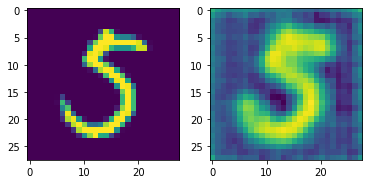

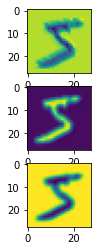

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

from tqdm import tqdm

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset = datasets.MNIST(
    root='PATH',
    transform=transforms.ToTensor(),
    download=True
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
with tqdm(total=int(len(loader)), position=0, leave=False) as pber:
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            
            pber.update(1)
            # print('Epoch {}, Batch idx {}, loss {}'.format(
            #     epoch, batch_idx, loss.item()))


In [ ]:
def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])

In [23]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 28, 28]              30
         MaxPool2d-2            [-1, 3, 14, 14]               0
            Conv2d-3            [-1, 6, 14, 14]             168
         MaxPool2d-4              [-1, 6, 7, 7]               0
   ConvTranspose2d-5            [-1, 3, 14, 14]             291
   ConvTranspose2d-6            [-1, 1, 28, 28]              49
Total params: 538
Trainable params: 538
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


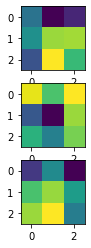

In [24]:
# Visualize conv filter
kernels = model.conv1.weight.detach()
fig, axarr = plt.subplots(kernels.size(0))
for idx in range(kernels.size(0)):
    axarr[idx].imshow(kernels[idx].squeeze())